In [42]:
from datetime import timedelta, datetime, timezone

import pandas as pd
from matplotlib import pyplot as plt

from data.flux.spec.data import Flux
from utils.range import DateTimeRange

# Section: flux, label
sections: list[tuple[Flux, DateTimeRange, str]] = []

In [2]:
"""
Load interesting sections from the archive data.
"""
from importer.flux.archive import _from_timeseries, _select_best_sources
from data.flux.spec.channel import FrequencyBand
from sunpy.timeseries import TimeSeries
from sunpy.net import Fido
from sunpy.net import attrs
from sunpy import config
import os
import glob

# Sample dates with various edge cases
ARCHIVE_DATES = (
    '1980-05-28', '1980-06-15', '1980-06-27', '1980-07-13', '1980-09-25',
    '1980-09-28', '1984-02-06', '1984-09-20', '1985-05-02', '1985-07-01',
    '1985-08-31', '1985-09-08', '1985-12-02', '1986-02-26', '1986-04-07',
    '1986-07-28', '1986-09-09', '1986-09-17', '1987-09-03', '1988-03-22',
    '1991-04-30', '1995-10-04', '1995-10-06', '1996-07-07', '2002-12-19',
    '2002-12-20', '2008-09-14', '2009-09-22', '2017-09-06'
)
ARCHIVE_SECTION_SIZE = timedelta(days=3)


def _search_cached(time_range: DateTimeRange) -> tuple[list[str], bool]:
    cache_dir = config.get('downloads', 'download_dir')
    dates = pd.date_range(time_range.start, time_range.end, freq='D')
    cached_files = []
    for sub_date in dates:
        for pattern in (
                f'go??{sub_date.strftime("%y%m%d")}.fits',
                f'sci_*xrs*-l2-*_g*_d{sub_date.strftime("%Y%m%d")}_v*.nc'
        ):
            candidates = glob.glob(os.path.join(cache_dir, pattern))
            if len(candidates) == 0:
                continue
            cached_files.append(candidates[0])
            break
    return cached_files, len(cached_files) == len(dates)


def _search_and_fetch(time_range: DateTimeRange):
    # Search available data
    results = Fido.search(
        attrs.Time(time_range.start, time_range.end),
        attrs.Instrument("XRS")
    )[0]

    # Select newest satellite
    satellite = max(*results['SatelliteNumber'])
    results = _select_best_sources(
        results[results['SatelliteNumber'] == satellite]
    )

    # Download data files
    return Fido.fetch(results)


for date_str in ARCHIVE_DATES:
    start_date = datetime.fromisoformat(date_str).replace(tzinfo=timezone.utc)
    time_range = DateTimeRange(start_date, start_date + ARCHIVE_SECTION_SIZE)
    print(f'Loading {time_range}')

    files, is_cache_complete = _search_cached(time_range)
    if is_cache_complete:
        print('Loading from cache')
    else:
        try:
            files = _search_and_fetch(time_range)
        except Exception as e:
            print(f'Failed to search and download {date_str}: {e}')
    if len(files) == 0:
        print('Download failed or no data found.')
        continue

    series = TimeSeries(files, concatenate=True).to_dataframe()
    for band in (FrequencyBand.SHORT, FrequencyBand.LONG):
        sections.append((
            _from_timeseries(series, band),
            time_range,
            f'{date_str} {band.name}'
        ))

Loading 1980-05-28 00:00:00+00:00 - 1980-05-31 00:00:00+00:00
Loading from cache
Loading 1980-06-15 00:00:00+00:00 - 1980-06-18 00:00:00+00:00
Loading from cache
Loading 1980-06-27 00:00:00+00:00 - 1980-06-30 00:00:00+00:00
Loading from cache
Loading 1980-07-13 00:00:00+00:00 - 1980-07-16 00:00:00+00:00
Loading from cache
Loading 1980-09-25 00:00:00+00:00 - 1980-09-28 00:00:00+00:00
Loading from cache
Loading 1980-09-28 00:00:00+00:00 - 1980-10-01 00:00:00+00:00
Loading from cache
Loading 1984-02-06 00:00:00+00:00 - 1984-02-09 00:00:00+00:00
Loading from cache
Loading 1984-09-20 00:00:00+00:00 - 1984-09-23 00:00:00+00:00
Loading from cache
Loading 1985-05-02 00:00:00+00:00 - 1985-05-05 00:00:00+00:00
Loading from cache
Loading 1985-07-01 00:00:00+00:00 - 1985-07-04 00:00:00+00:00
Loading from cache
Loading 1985-08-31 00:00:00+00:00 - 1985-09-03 00:00:00+00:00
Loading from cache
Loading 1985-09-08 00:00:00+00:00 - 1985-09-11 00:00:00+00:00
Loading from cache
Loading 1985-12-02 00:00:00+

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

Loading 1995-10-06 00:00:00+00:00 - 1995-10-09 00:00:00+00:00


Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

Loading 1996-07-07 00:00:00+00:00 - 1996-07-10 00:00:00+00:00
Loading from cache
Loading 2002-12-19 00:00:00+00:00 - 2002-12-22 00:00:00+00:00
Loading from cache
Loading 2002-12-20 00:00:00+00:00 - 2002-12-23 00:00:00+00:00
Loading from cache
Loading 2008-09-14 00:00:00+00:00 - 2008-09-17 00:00:00+00:00
Loading from cache
Loading 2009-09-22 00:00:00+00:00 - 2009-09-25 00:00:00+00:00
Loading from cache
Loading 2017-09-06 00:00:00+00:00 - 2017-09-09 00:00:00+00:00
Loading from cache


In [3]:
"""
Load all available live data.
Is a separate case because it is minute averaged.
"""
from importer.flux.live import _select_live_url, _from_live_json
from aiohttp import ClientSession
from data.flux.spec.channel import FrequencyBand

live_end = datetime.now(timezone.utc)
live_range = DateTimeRange(live_end - timedelta(days=7), live_end)
async with ClientSession() as session:
    async with session.get(_select_live_url(True, live_range.start)) as response:
        json = await response.json()
        for band in (FrequencyBand.SHORT, FrequencyBand.LONG):
            live_flux = _from_live_json(json, band, live_range.start)[0]
            sections.append((live_flux, live_range, f'live {band.name}'))

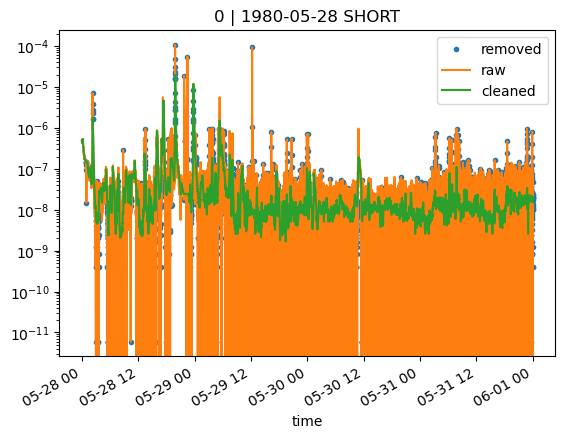

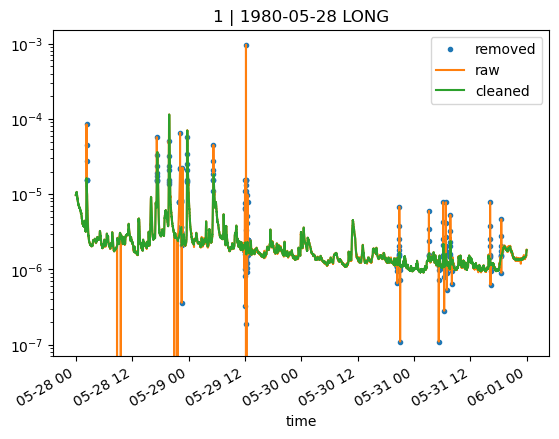

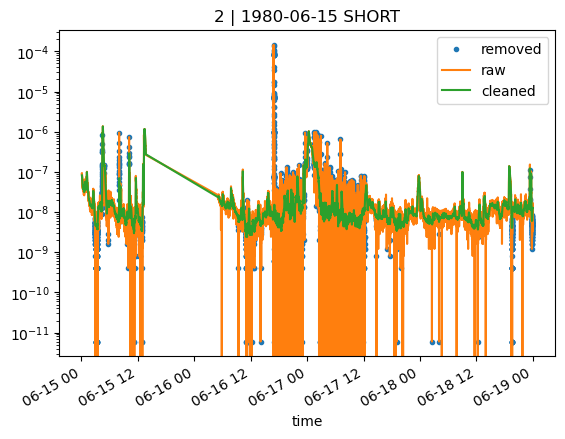

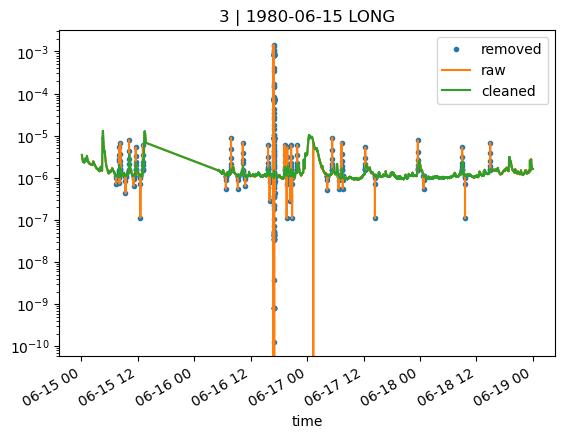

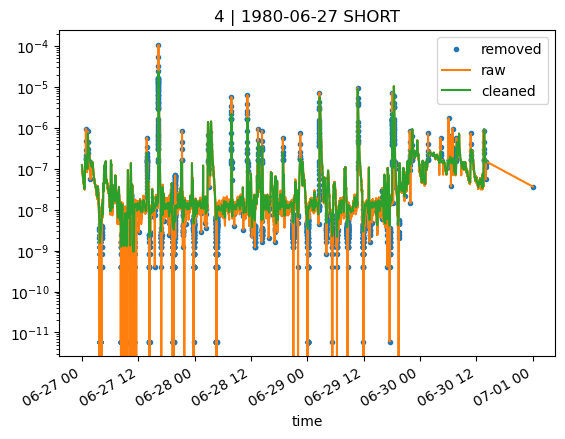

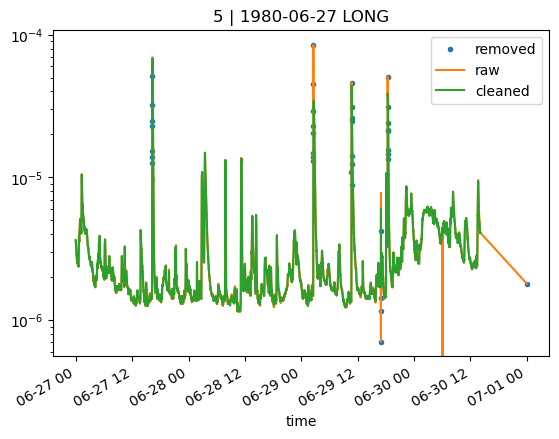

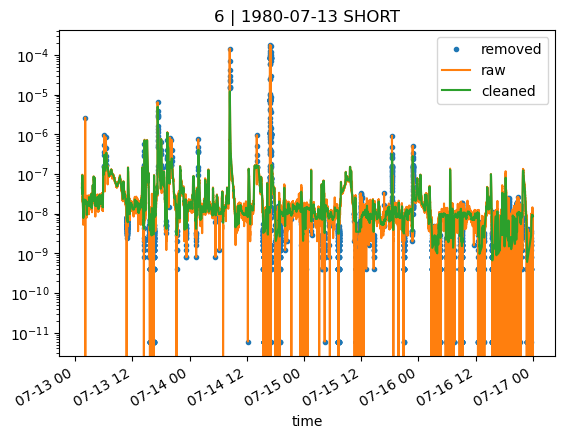

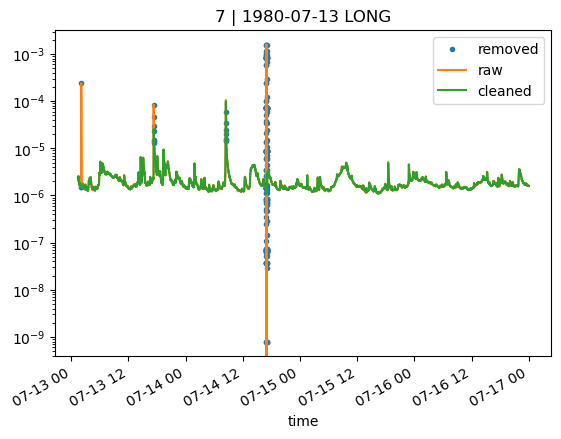

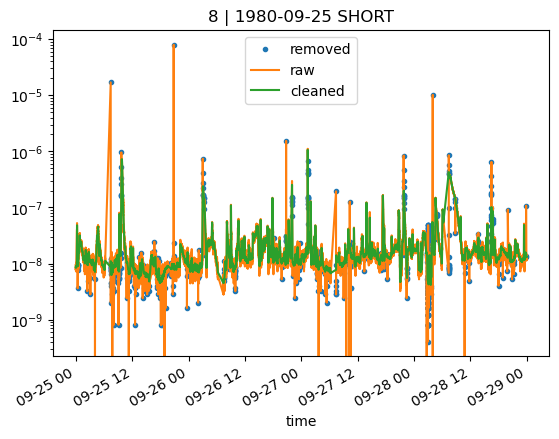

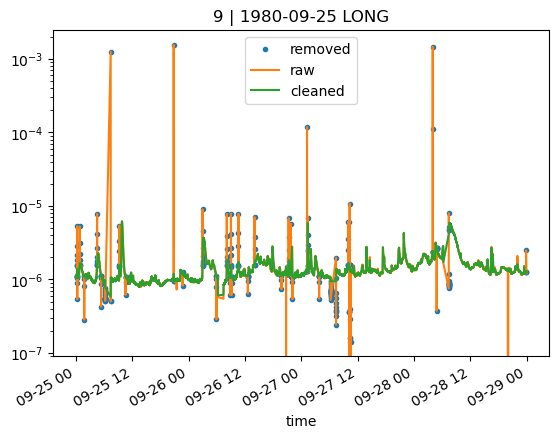

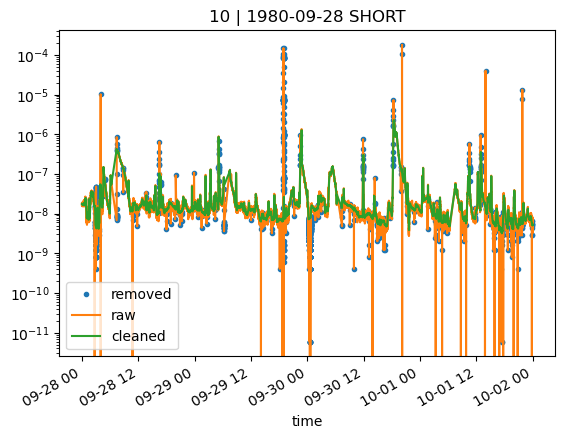

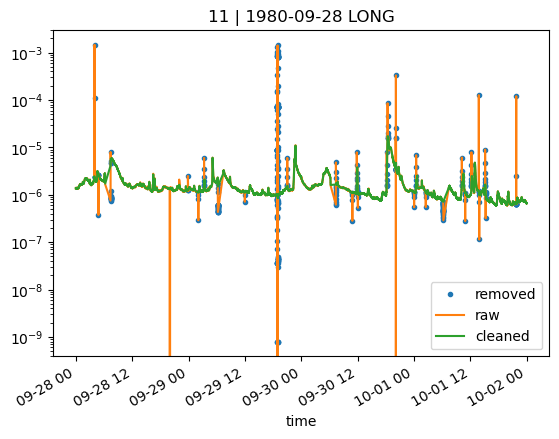

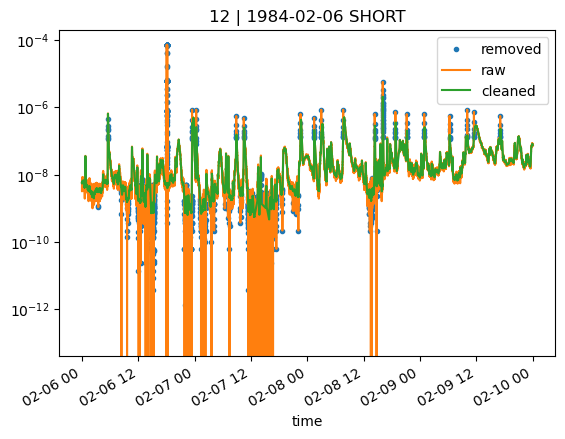

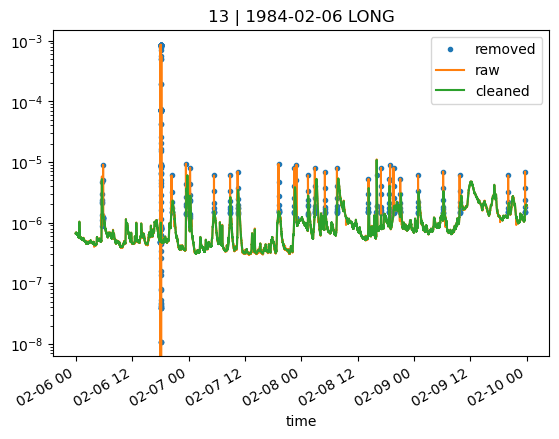

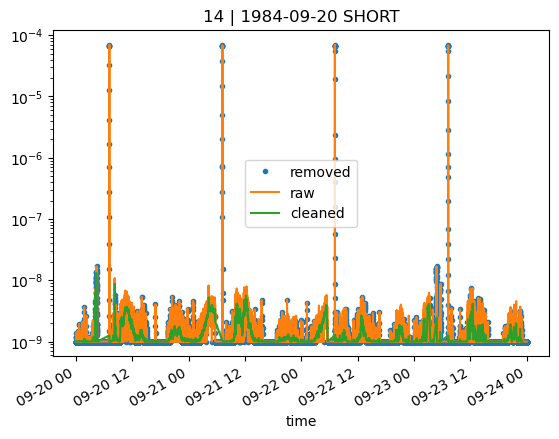

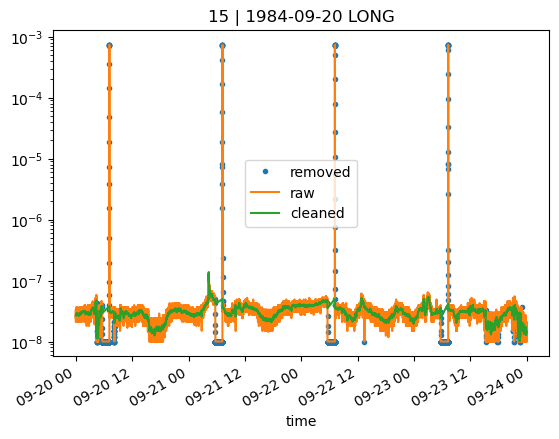

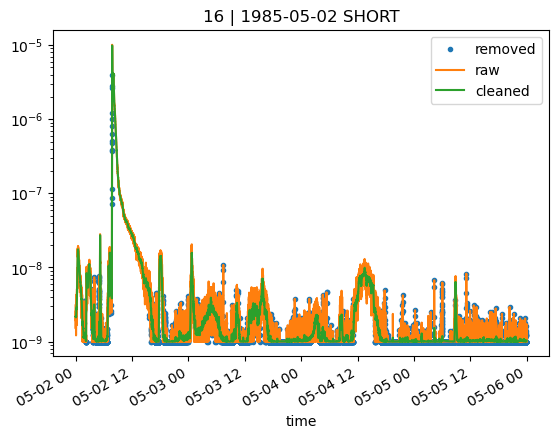

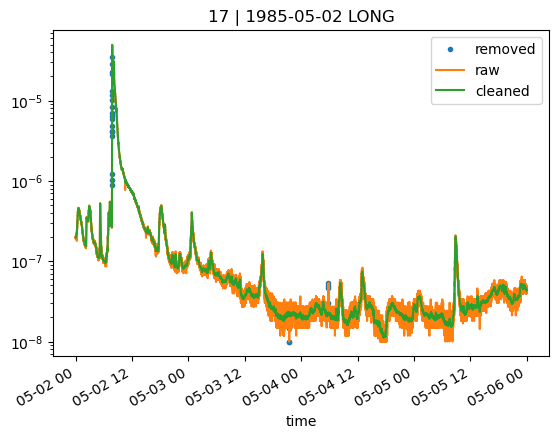

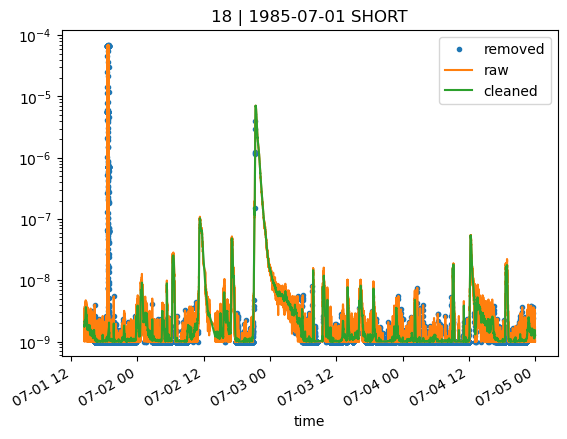

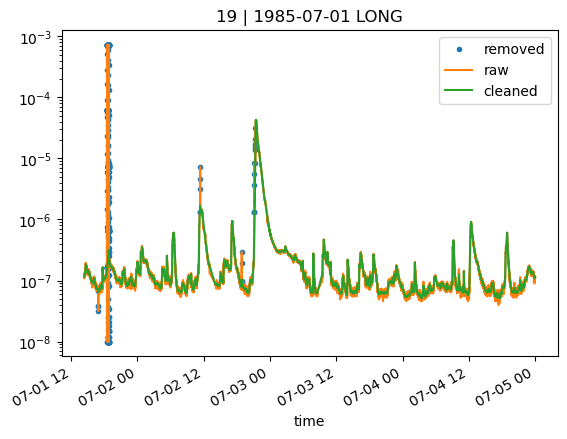

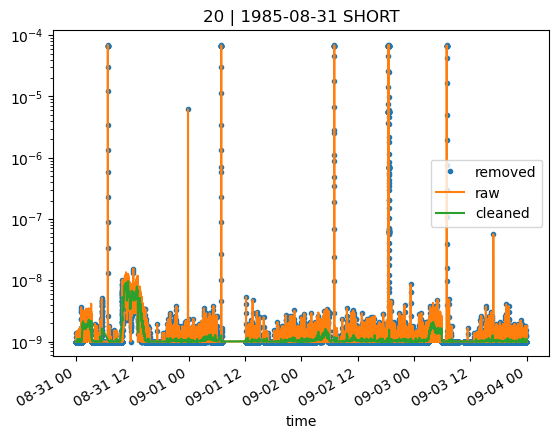

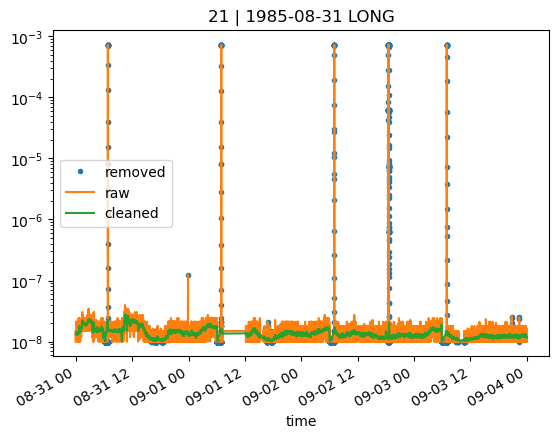

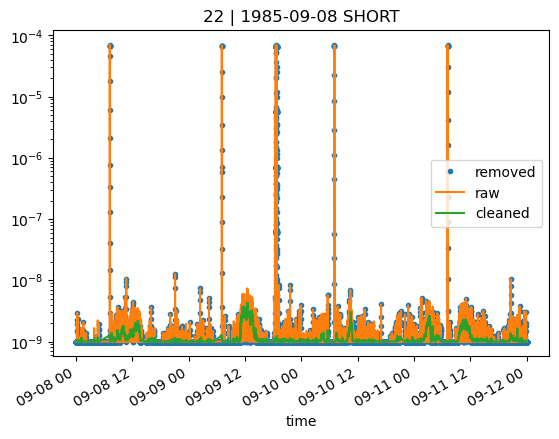

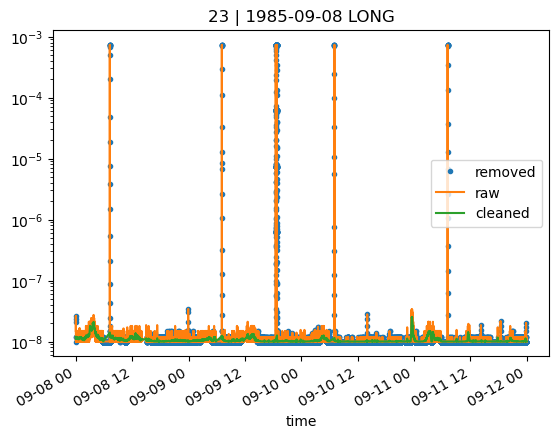

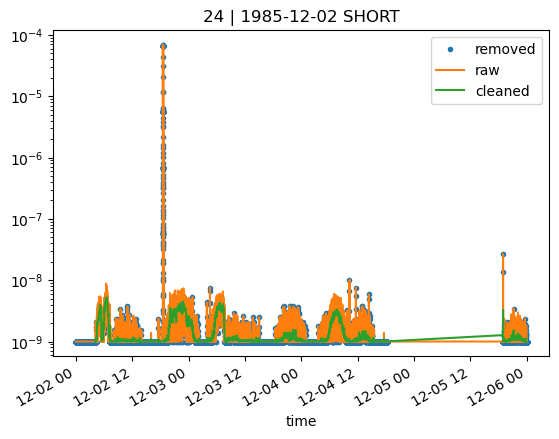

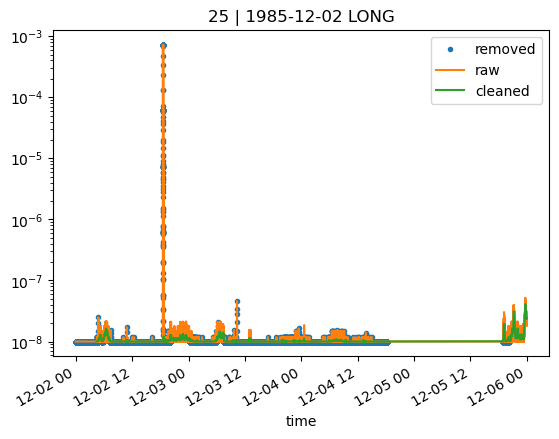

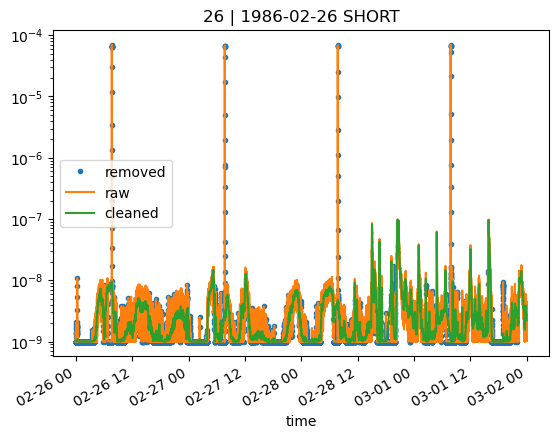

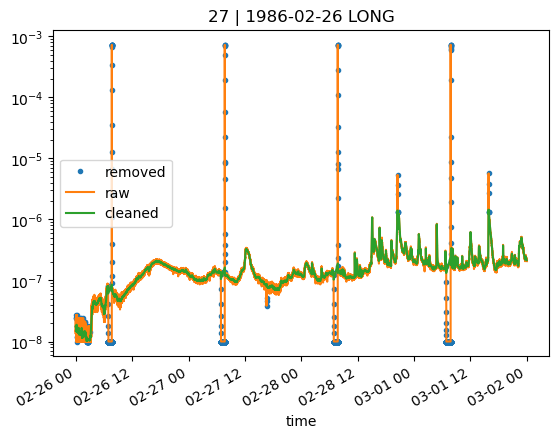

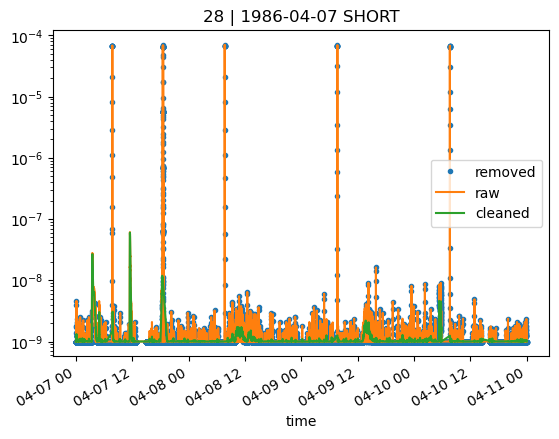

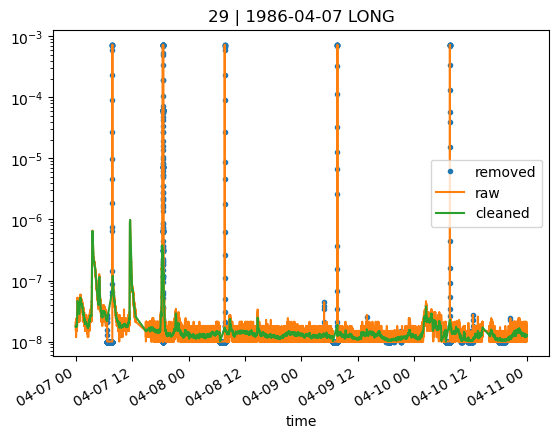

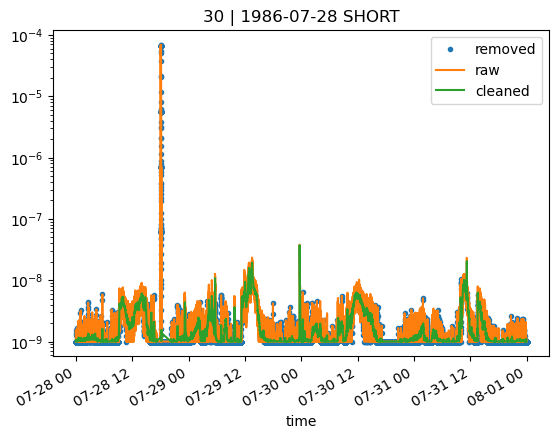

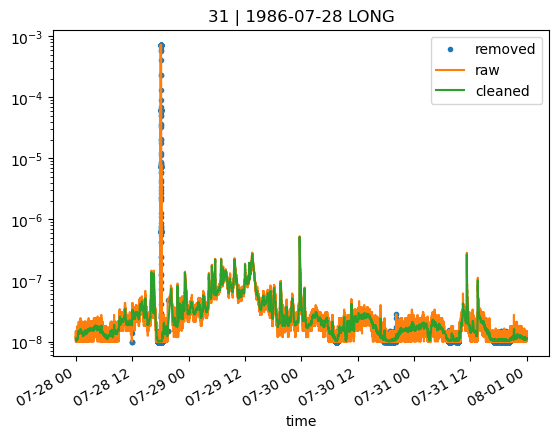

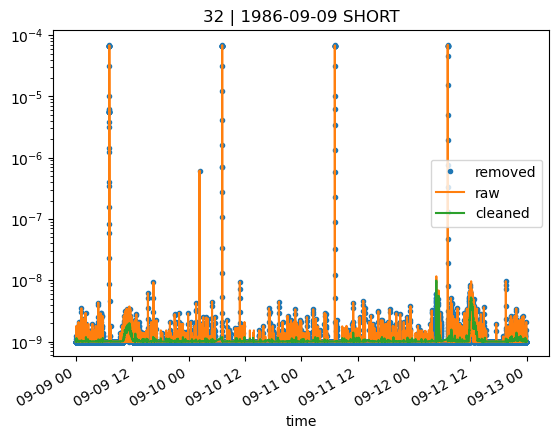

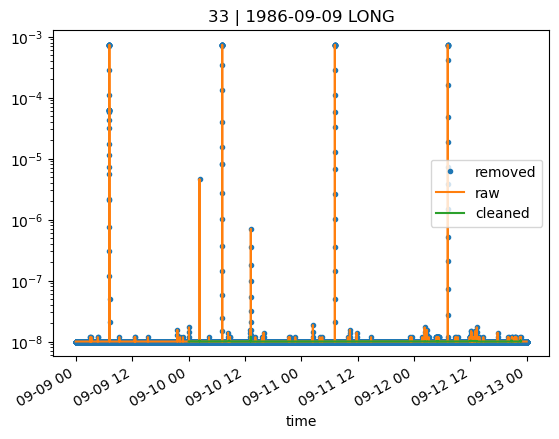

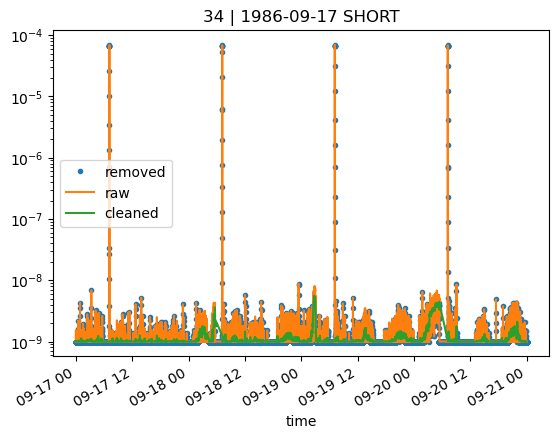

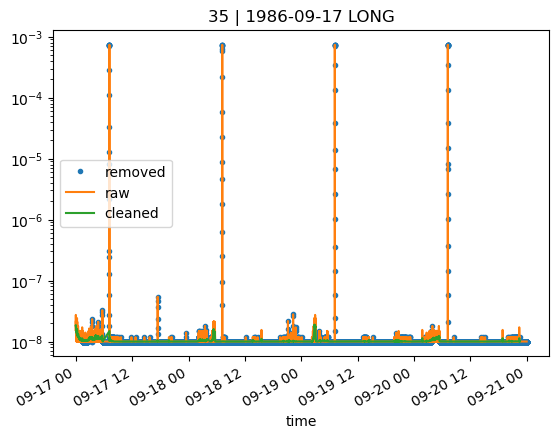

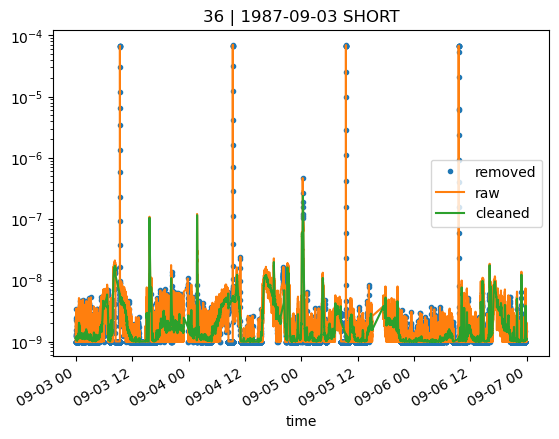

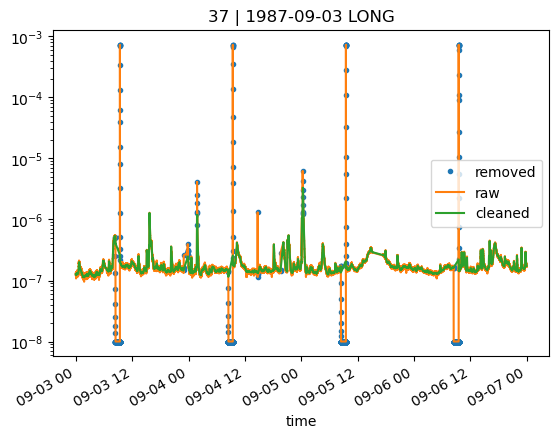

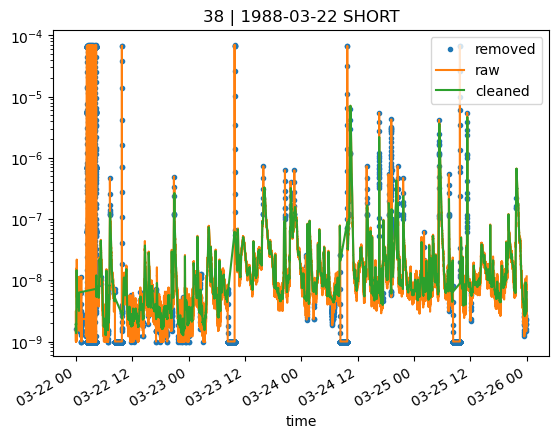

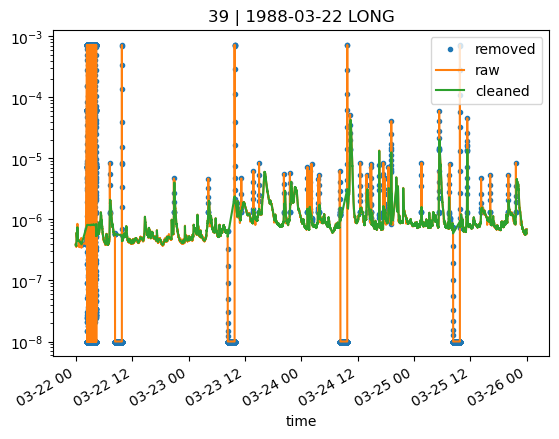

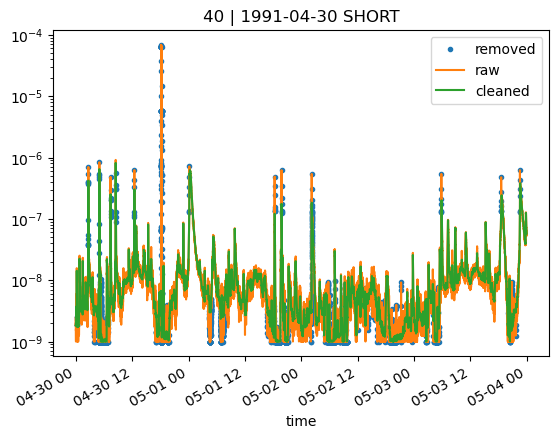

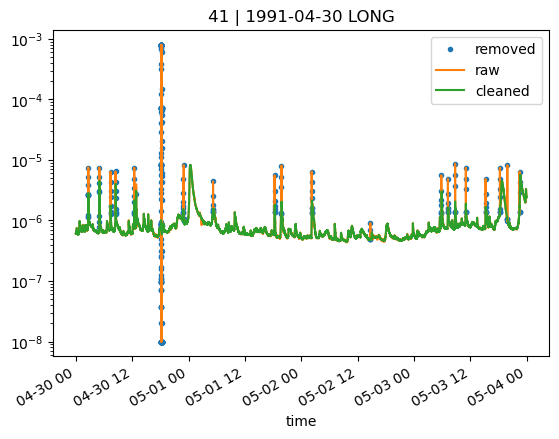

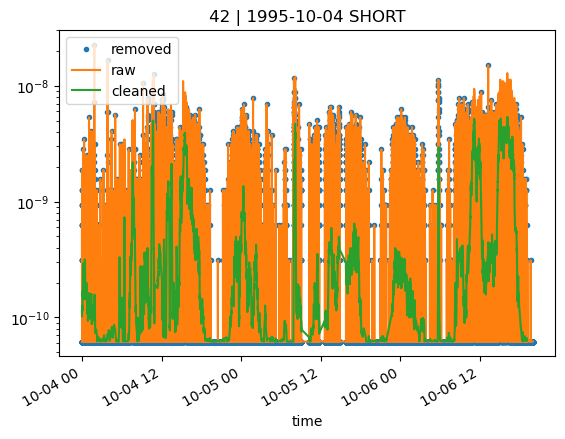

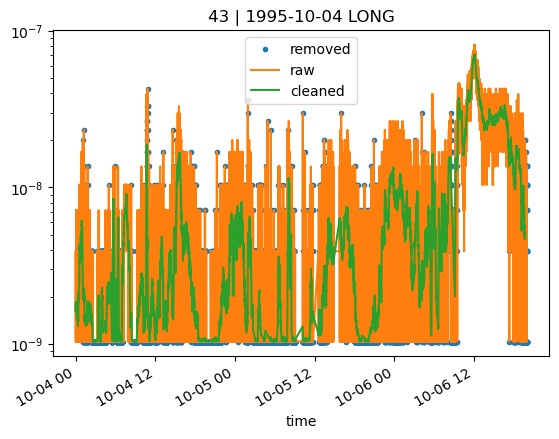

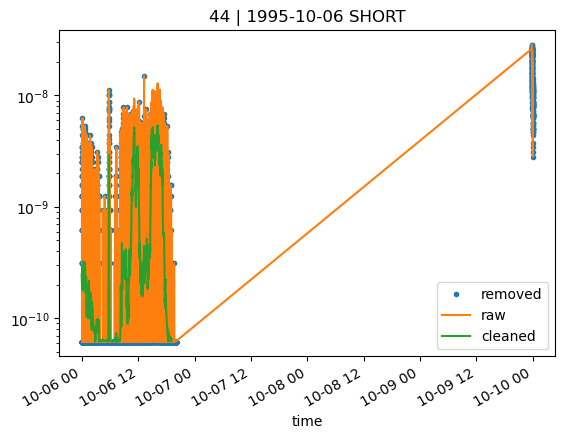

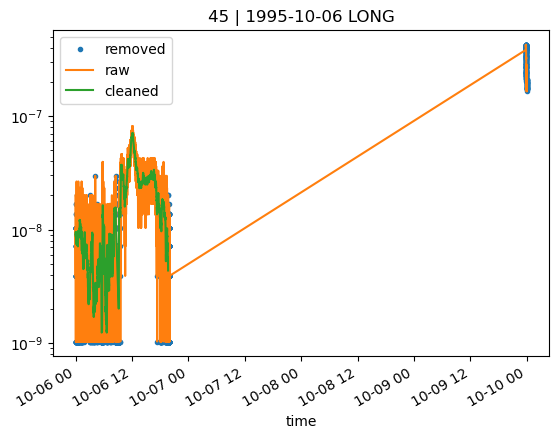

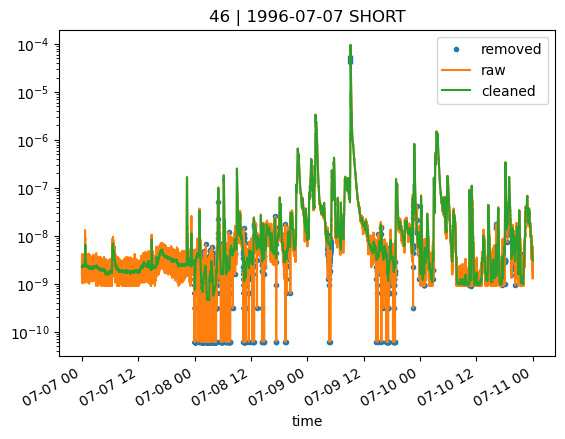

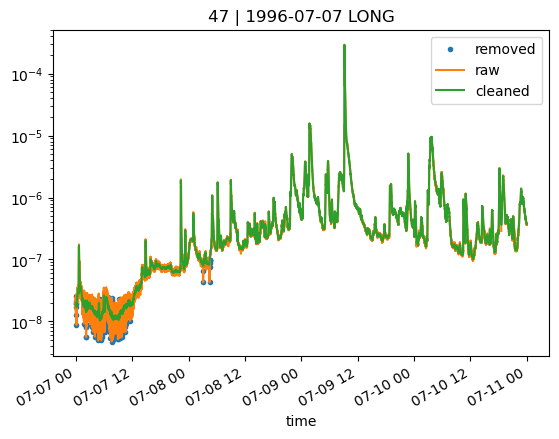

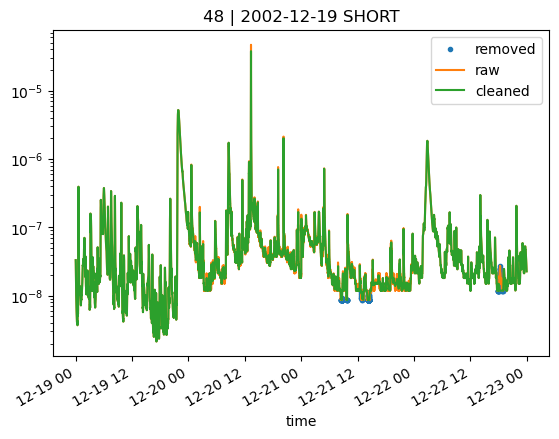

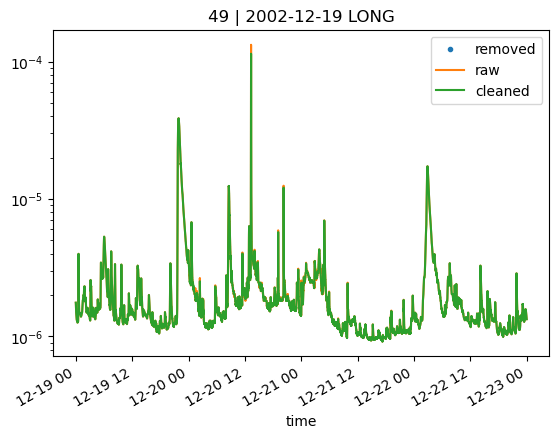

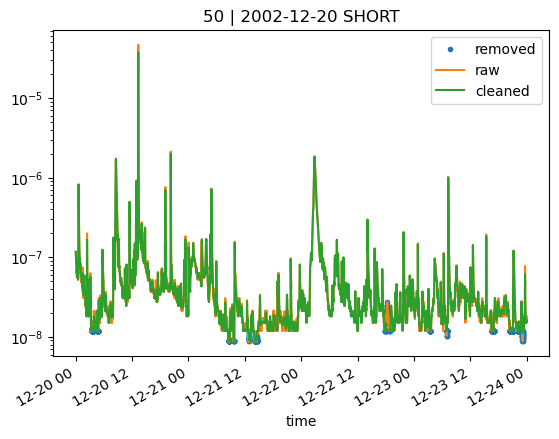

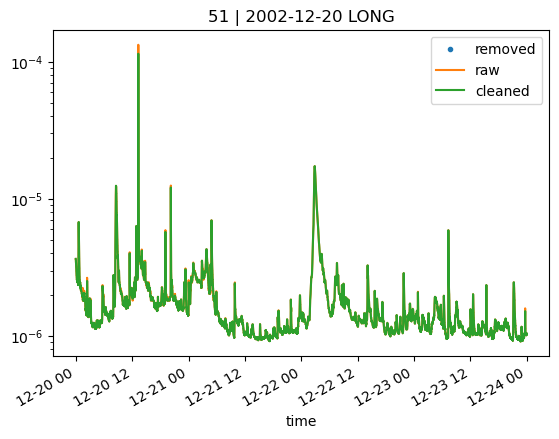

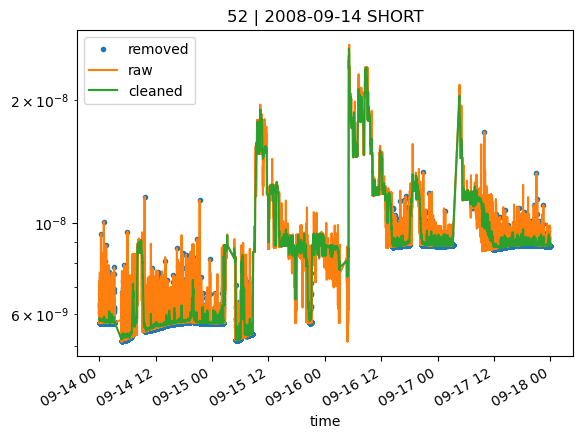

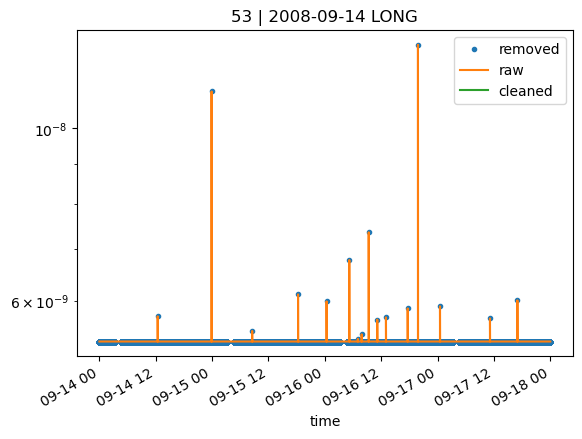

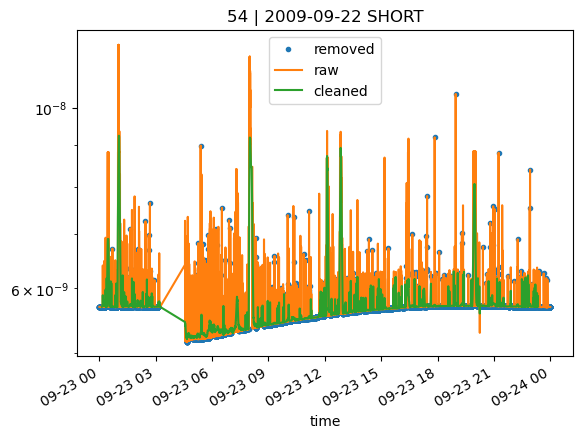

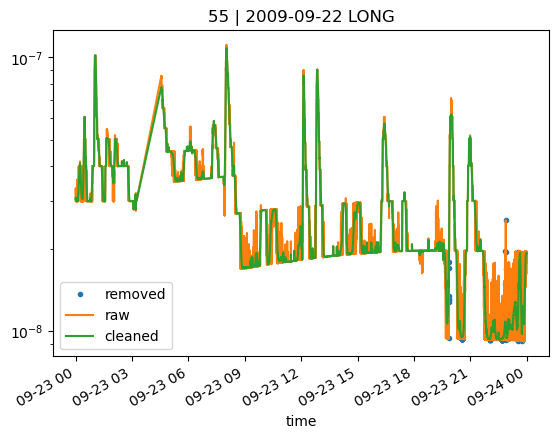

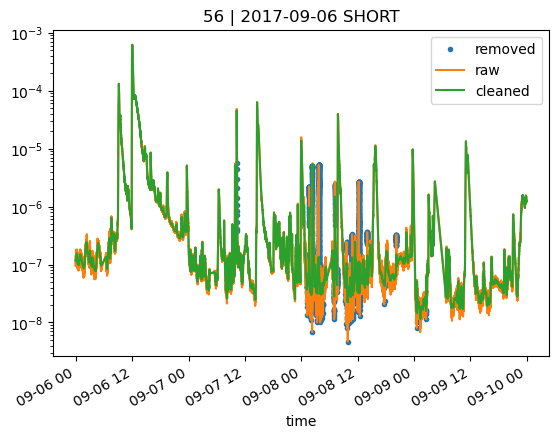

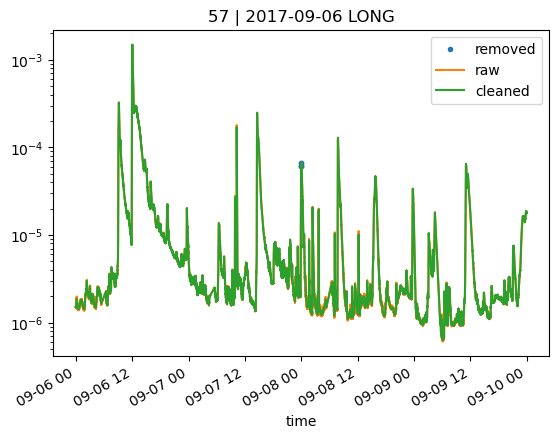

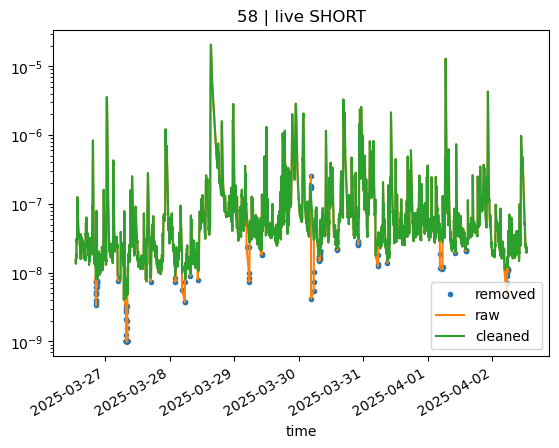

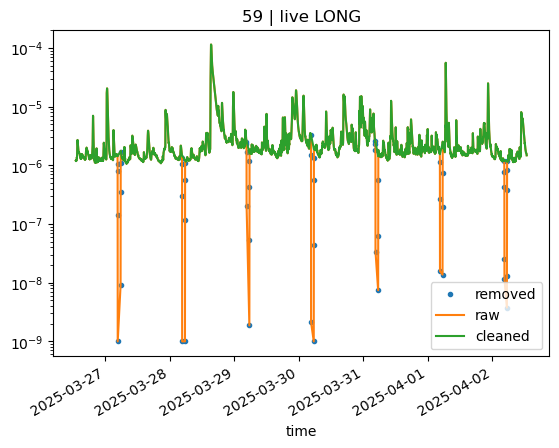

In [41]:
import importlib
import importer.flux._clean as clean_module

# Reload clean module for easier development
importlib.reload(clean_module)
clean_flux = clean_module.clean_flux

for i, (raw, time_range, label) in enumerate(sections):
    cleaned = clean_flux(raw, time_range)
    ax = raw[~raw.index.isin(cleaned.index)].plot(
        title=f'{i} | {label}',
        logy=True,
        marker='.',
        linestyle='none',
        label='removed'
    )
    raw.rename('raw').plot(ax=ax)
    cleaned.rename('cleaned').plot(ax=ax)
    plt.legend()
    plt.show()